In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

In [40]:
class Point:
    def __init__(self, 
                 x_pos: float = None, 
                 y_pos: float = None, 
                 is_border: bool = False, 
                 is_airfoil: bool = False, 
                 U_infinity: float = 30):
        """
        Initialize a Point instance.
        
        Parameters:
        x_pos (float): The x-coordinate of the point.
        y_pos (float): The y-coordinate of the point.
        is_border (bool): Indicates if the point is on the border.
        is_airfoil (bool): Indicates if the point is part of an airfoil.
        U_infinity (float): The freestream velocity.
        """
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.is_border = is_border
        self.is_airfoil = is_airfoil
        self.U_infinity = U_infinity
        self._preprocess()
    
    def _preprocess(self):
        """
        Initialize default values for various attributes of the flow.
        """
        self.streamline = 0
        self.del_streamline_del_x_value = 0
        self.del_streamline_del_y_value = 0
        self.pressure = 0
        self.absolute_velocity = 0
        self.is_point_A = False
        self.is_point_B = False
        self.is_in_airfoil_surface = False
        self.normal_direction = None
        self.g = 9.8
        self.density = 1
        self.bernoulli_result = 10E5 / (self.density * self.g)
        
    def set_streamline(self, streamline):
        """
        Set the streamline value, with a special condition if the point is part of an airfoil.
        
        Parameters:
        streamline (float): The streamline value to set.
        """
        if self.is_airfoil:
            streamline = 0
        self.streamline = streamline
        
    def get_del_streamline_del_x(self):
        """
        Get the x-component of the streamline gradient.
        
        Returns:
        float: The x-component of the streamline gradient, 0 if the point is on the border or part of an airfoil.
        """
        if self.is_border or self.is_airfoil:
            return 0
        return self.del_streamline_del_x_value
    
    def set_del_streamline_del_x(self, stream_line):
        """
        Set the x-component of the streamline gradient.
        
        Parameters:
        stream_line (float): The x-component of the streamline gradient to set.
        """
        if not self.is_airfoil and not self.is_border:
            self.del_streamline_del_x_value = stream_line
    
    def get_del_streamline_del_y(self):
        """
        Get the y-component of the streamline gradient.
        
        Returns:
        float: The y-component of the streamline gradient, U_infinity if the point is on the border, 
               0 if the point is part of an airfoil.
        """
        if self.is_border:
            return self.U_infinity
        elif self.is_airfoil:
            return 0
        return self.del_streamline_del_y_value
    
    def set_del_streamline_del_y(self, stream_line):
        """
        Set the y-component of the streamline gradient.
        
        Parameters:
        stream_line (float): The y-component of the streamline gradient to set.
        """
        if not self.is_airfoil and not self.is_border:
            self.del_streamline_del_y_value = stream_line
            
    def calculate_absolute_velocity(self):
        """
        Calculate the absolute velocity based on the streamline gradients.
        """
        del_in_x = self.get_del_streamline_del_x()
        del_in_y = self.get_del_streamline_del_y()
        self.absolute_velocity = np.sqrt(del_in_x**2 + del_in_y**2)

    def calculate_pressure(self):
        """
        Calculate the pressure at the point using Bernoulli's equation.
        """
        if self.is_airfoil:
            return
        self.pressure = self.density * self.g * (
            self.bernoulli_result - (self.absolute_velocity**2) / 2 * self.g)


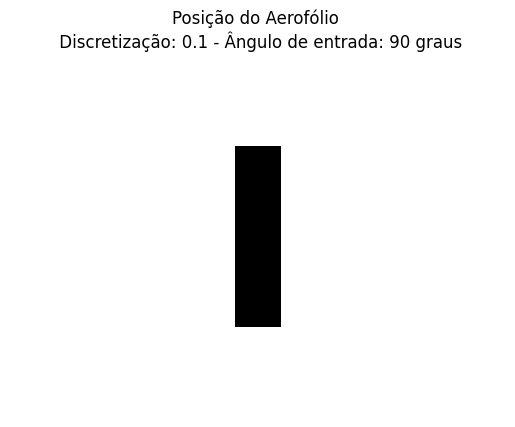

Iteration: 1 - Max Error: 1.0
Iteration: 2 - Max Error: 1.00001
Iteration: 3 - Max Error: 1.00003
Iteration: 4 - Max Error: 1.00012
Iteration: 5 - Max Error: 1.00035
Iteration: 6 - Max Error: 1.00084
Iteration: 7 - Max Error: 1.00181
Iteration: 8 - Max Error: 1.00363
Iteration: 9 - Max Error: 1.0069
Iteration: 10 - Max Error: 1.01257
Iteration: 11 - Max Error: 1.02215
Iteration: 12 - Max Error: 1.03813
Iteration: 13 - Max Error: 1.06462
Iteration: 14 - Max Error: 1.28289
Iteration: 15 - Max Error: 12.15176
Iteration: 16 - Max Error: 6.25283
Iteration: 17 - Max Error: 5.87203
Iteration: 18 - Max Error: 14.29586
Iteration: 19 - Max Error: 8.16513
Iteration: 20 - Max Error: 98.08506
Iteration: 21 - Max Error: 141.6246
Iteration: 22 - Max Error: 359.16828
Iteration: 23 - Max Error: 514.27431
Iteration: 24 - Max Error: 237.38832
Iteration: 25 - Max Error: 62.52489
Iteration: 26 - Max Error: 916.51039
Iteration: 27 - Max Error: 27.96477
Iteration: 28 - Max Error: 143.4864
Iteration: 29 - Max

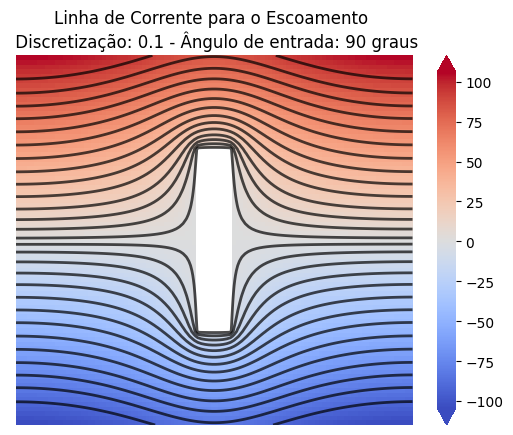

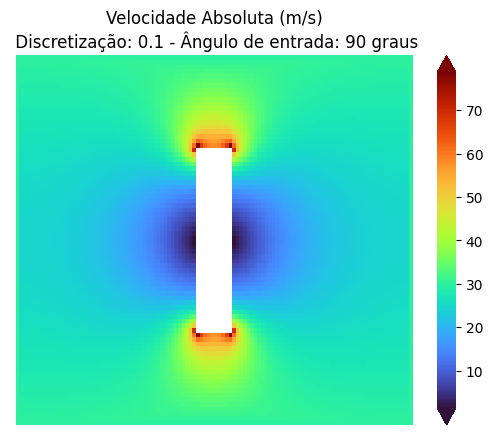

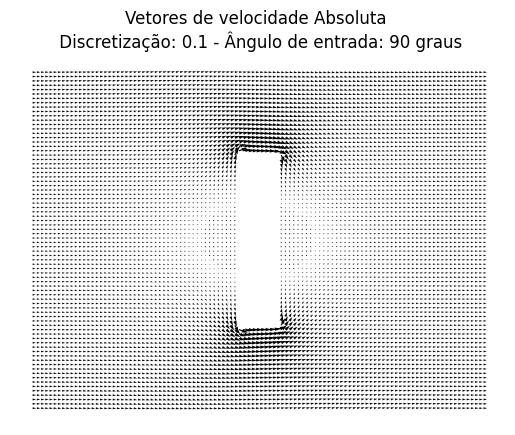

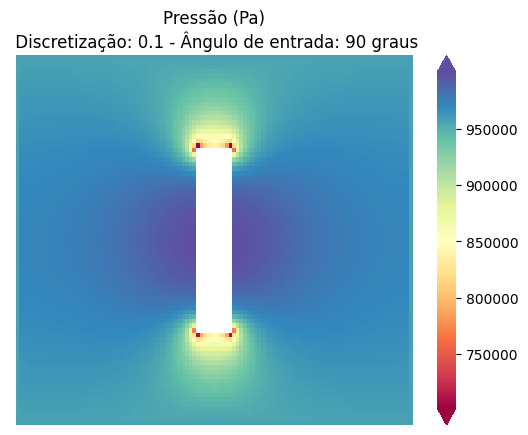

drag: -0.970400280726079 lift: -529.843302796279


In [51]:
class Mesh:
    def __init__(self, delta: float = 0.01, 
                 rotation_angle_in_degrees: float = 0, 
                 U_infinity: float = 30, 
                 max_num_of_iterations: float = 10E4):
        """
        Initialize a Mesh instance.
        
        Parameters:
        delta (float): Grid spacing.
        rotation_angle_in_degrees (float): Rotation angle of the airfoil in degrees.
        U_infinity (float): Freestream velocity.
        max_num_of_iterations (float): Maximum number of iterations allowed for the simulation.
        """
        self.delta = delta
        self.lambda_value = 1.85
        self.tolerance = 0.01
        self.rotation_angle_in_degrees = rotation_angle_in_degrees
        self.rotation_angle = rotation_angle_in_degrees * np.pi / 180
        self.U_infinity = U_infinity
        self.max_num_of_iterations = max_num_of_iterations
        self._preprocess()
    
    def _preprocess(self):
        """
        Preprocess the mesh and initialize parameters related to the airfoil and grid.
        """
        mesh_width = 11
        mesh_height = 8
        self.airfoil_width = 1
        self.airfoil_height = 4
        self.num_of_iterations = 0
        self.drag_forces = None
        self.lifting_forces = None
        # Parameters related to the rotation of the airfoil
        self.rotation_matrix = np.array([[-np.sin(self.rotation_angle), np.cos(self.rotation_angle)],
                                         [-np.cos(self.rotation_angle), -np.sin(self.rotation_angle)]])
        self.airfoil_center = np.array([mesh_width / 2, mesh_height / 2])
        new_system_center = self.rotation_matrix @ self.airfoil_center        
        self.p1 = new_system_center + np.array([self.airfoil_width / 2, self.airfoil_height / 2]) 
        self.p2 = new_system_center + np.array([-self.airfoil_width / 2, -self.airfoil_height / 2]) 
        self.normal_in_I = np.array([np.sin(self.rotation_angle), np.cos(self.rotation_angle)])
        self.normal_in_J = np.array([-np.cos(self.rotation_angle), np.sin(self.rotation_angle)])
        
        # Initializes the mesh object
        self.num_of_cols = int(mesh_width / self.delta)    
        self.num_of_rows = int(mesh_height / self.delta)    
        self.mesh = [[None] * self.num_of_cols for _ in range(self.num_of_rows)]
        for col_id in range(self.num_of_cols):
            for row_id in range(self.num_of_rows):
                new_x = (self.delta / 2) * (2 * col_id + 1)
                new_y = (self.delta / 2) * (2 * row_id + 1)
                new_point = Point(x_pos=new_x, y_pos=new_y, U_infinity=self.U_infinity)
                is_airfoil = self.is_in_airfoil(new_point) # Check if a point is part of the airfoil
                new_point.is_airfoil = is_airfoil
                if (row_id == 0 or 
                    col_id == 0 or 
                    row_id == (self.num_of_rows - 1) or 
                    col_id == (self.num_of_cols - 1)):
                    new_point.is_border = True
                self.mesh[row_id][col_id] = new_point
                
        # Define the points in contact with the airfoil
        for col_id in range(1, self.num_of_cols - 1):
            for row_id in range(1, self.num_of_rows - 1):
                self.center_point = self.mesh[row_id][col_id]
                if not self.center_point.is_airfoil:
                    self.left_point = self.mesh[row_id][col_id - 1]
                    self.right_point = self.mesh[row_id][col_id + 1]
                    self.upper_point = self.mesh[row_id - 1][col_id]
                    self.lower_point = self.mesh[row_id + 1][col_id]
                    if (self.left_point.is_airfoil
                        or self.right_point.is_airfoil
                        or self.upper_point.is_airfoil
                        or self.lower_point.is_airfoil):
                        self.define_normal_of_surface(row_id, col_id)
    
    def define_normal_of_surface(self, row_id, col_id):
        """
        Define the surface normal for points on the airfoil surface.
        
        Parameters:
        row_id (int): Row index of the point.
        col_id (int): Column index of the point.
        """
        point_position = np.array([self.center_point.x_pos, self.center_point.y_pos]) - self.airfoil_center
        point_position_in_new_system = self.rotation_matrix @ point_position
        point_position_in_new_system = point_position_in_new_system * (1 + self.delta)
        new_x = point_position_in_new_system[0]
        new_y = point_position_in_new_system[1]
        self.mesh[row_id][col_id].is_in_airfoil_surface = True
        # Define the normal direction related to the point in the airfoil surface
        if new_x >= (self.airfoil_width / 2):
            self.mesh[row_id][col_id].normal_direction = -self.normal_in_I
        elif new_x <= -(self.airfoil_width / 2):
            self.mesh[row_id][col_id].normal_direction = self.normal_in_I
        elif new_y >= (self.airfoil_height / 2):
            self.mesh[row_id][col_id].normal_direction = self.normal_in_J
        elif new_y <= -(self.airfoil_height / 2):
            self.mesh[row_id][col_id].normal_direction = -self.normal_in_J
    
    def is_in_airfoil(self, point):
        """
        Determine if a point is within the airfoil.
        
        Parameters:
        point (Point): The point to check.
        
        Returns:
        bool: True if the point is in the airfoil, False otherwise.
        """
        x_pos = point.x_pos
        y_pos = point.y_pos
        position_in_new_system = self.rotation_matrix @ np.array([x_pos, y_pos])
        new_x, new_y = position_in_new_system[0], position_in_new_system[1]
        in_x = (self.p1[0] > new_x and self.p2[0] < new_x)
        in_y = (self.p1[1] > new_y and self.p2[1] < new_y)
        if in_x and in_y:
            return True
        return False
        
    def get_parameter_value(self, 
                            streamline: bool = False, 
                            velocity: bool = False, 
                            pressure: bool = False):  
        """
        Get a specific parameter value (streamline, velocity, pressure) for the entire mesh.
        
        Parameters:
        streamline (bool): Whether to get streamline values.
        velocity (bool): Whether to get velocity values.
        pressure (bool): Whether to get pressure values.
        
        Returns:
        list: A mesh like matrix containing the requested parameter values.
        """
        mesh = [[None] * self.num_of_cols for _ in range(self.num_of_rows)]
        for row_id in range(self.num_of_rows): 
            for col_id in range(self.num_of_cols):   
                if streamline:
                    mesh[row_id][col_id] = self.mesh[row_id][col_id].streamline
                elif velocity:
                    mesh[row_id][col_id] = self.mesh[row_id][col_id].absolute_velocity
                elif pressure:
                    mesh[row_id][col_id] = self.mesh[row_id][col_id].pressure
                else:
                    raise Exception("Must set a parameter to get value")
        return mesh
        
    def apply_overelaxing(self, old_value, calculated_value):
        """
        Apply the over-relaxation technique to update the value.
        
        Parameters:
        old_value (float): The previous value.
        calculated_value (float): The newly calculated value.
        
        Returns:
        tuple: The new value and the error.
        """
        new_value = self.lambda_value * calculated_value + (1 - self.lambda_value) * old_value
        try:
            error = np.absolute((new_value - old_value) / new_value)
        except:
            return 0, 0
        return new_value, error
    
    def calculate_point_is_border(self):
        """
        Calculate the streamline value for border points according to each specific condition.
        
        Returns:
        float: The calculated streamline value.
        """
        calculated_value = 0            
        if self.upper_point is None:
            if self.left_point is None: 
                # Superior and entrance
                calculated_value = (2 * self.right_point.streamline + 
                                    2 * self.lower_point.streamline + 
                                    2 * self.delta * self.U_infinity) / 4
            elif self.right_point is None: 
                # Superior and output 
                calculated_value = (2 * self.left_point.streamline + 
                                    2 * self.lower_point.streamline + 
                                    2 * self.delta * self.U_infinity) / 4
            else:
                # Only superior
                calculated_value = (self.left_point.streamline +
                                    self.right_point.streamline +
                                    2 * self.lower_point.streamline + 
                                    2 * self.delta * self.U_infinity) / 4
        elif self.lower_point is None:
            if self.left_point is None:
                # Inferior and entrance 
                calculated_value = (2 * self.right_point.streamline + 
                                    2 * self.upper_point.streamline 
                                    - 2 * self.delta * self.U_infinity) / 4
            elif self.right_point is None: 
                # Inferior and output
                calculated_value = (2 * self.left_point.streamline + 
                                    2 * self.upper_point.streamline
                                    - 2 * self.delta * self.U_infinity) / 4
            else:
                # Only inferior
                calculated_value = (self.left_point.streamline +
                                    self.right_point.streamline +
                                    2 * self.upper_point.streamline
                                    - 2 * self.delta * self.U_infinity) / 4
        elif self.left_point is None and ((self.upper_point is not None) 
                                          and (self.lower_point is not None)):
            # Only entrance
            calculated_value = (2 * self.right_point.streamline 
                                + self.lower_point.streamline 
                                + self.upper_point.streamline) / 4
        elif self.right_point is None and ((self.upper_point is not None) 
                                           and (self.lower_point is not None)):
            # Only output
            calculated_value = (2 * self.left_point.streamline 
                                + self.lower_point.streamline 
                                + self.upper_point.streamline) / 4
        
        return calculated_value
    
    def iter_streamline(self, row_id, col_id):
        """
        Perform one iteration of streamline calculation for a specific point.
        
        Parameters:
        row_id (int): Row index of the point.
        col_id (int): Column index of the point.
        
        Returns:
        float: The error of the new streamline value.
        """
        if row_id == 0:
            self.upper_point = None
        else: 
            self.upper_point = self.mesh[row_id - 1][col_id]
        if row_id == (self.num_of_rows - 1):
            self.lower_point = None
        else:
            self.lower_point = self.mesh[row_id + 1][col_id]
            
        if col_id == 0:
            self.left_point = None
        else:
            self.left_point = self.mesh[row_id][col_id - 1]
        if col_id == (self.num_of_cols - 1):
            self.right_point = None
        else:
            self.right_point = self.mesh[row_id][col_id + 1]
        
        center_point = self.mesh[row_id][col_id]
        old_streamline_value = center_point.streamline
        if center_point.is_airfoil: 
            # Is point A
            if center_point.is_point_A:
                calculated_streamline_value = (self.upper_point.streamline + 
                                          self.right_point.streamline) / 2
            # Is point B
            elif center_point.is_point_B:
                calculated_streamline_value = (self.right_point.streamline + 
                                           self.lower_point.streamline) / 2
            # Is in airfoil
            else:
                return 0
        elif center_point.is_border:
            # Point belongs to the border
            calculated_streamline_value = self.calculate_point_is_border()        
        else:            
            # Regular condition
            calculated_streamline_value = (self.upper_point.streamline + 
                                           self.left_point.streamline + 
                                           self.lower_point.streamline + 
                                           self.right_point.streamline) / 4
        # Overrelaxing method
        new_streamline_value, error = self.apply_overelaxing(
                        old_streamline_value, calculated_streamline_value)
        self.mesh[row_id][col_id].set_streamline(new_streamline_value)
        
        return error
    
    def calculate_derivates(self, row_id, col_id):
        """
        Calculate the derivatives of the streamline function for a specific point.
        Then defines velocity of the point and pressure
        
        Parameters:
        row_id (int): Row index of the point.
        col_id (int): Column index of the point.
        """
        center_point = self.mesh[row_id][col_id]
        if center_point.is_border or center_point.is_airfoil:
            self.mesh[row_id][col_id].calculate_absolute_velocity()
            self.mesh[row_id][col_id].calculate_pressure()
            return
        del_in_x = (self.right_point.streamline - self.left_point.streamline) / (2 * self.delta)
        del_in_y = (self.upper_point.streamline - self.lower_point.streamline) / (2 * self.delta)
        self.mesh[row_id][col_id].set_del_streamline_del_x(del_in_x)
        self.mesh[row_id][col_id].set_del_streamline_del_y(del_in_y)
        self.mesh[row_id][col_id].calculate_absolute_velocity()
        self.mesh[row_id][col_id].calculate_pressure()
    
    def calculate_velocity_and_pressure(self):
        """
        Calculate the velocity and pressure for all points in the mesh.
        """
        for row_id in range(self.num_of_rows): 
            for col_id in range(self.num_of_cols):   
                if row_id == 0:
                    self.upper_point = None
                else: 
                    self.upper_point = self.mesh[row_id - 1][col_id]
                if row_id == (self.num_of_rows - 1):
                    self.lower_point = None
                else:
                    self.lower_point = self.mesh[row_id + 1][col_id]
                    
                if col_id == 0:
                    self.left_point = None
                else:
                    self.left_point = self.mesh[row_id][col_id - 1]
                if col_id == (self.num_of_cols - 1):
                    self.right_point = None
                else:
                    self.right_point = self.mesh[row_id][col_id + 1]
                self.calculate_derivates(row_id, col_id)
                
    def calculate_forces(self):
        """
        Calculate the drag and lift forces on the airfoil.
        """
        num_of_points = 0
        drag_forces = 0
        lifting_forces = 0
        for row_id in range(self.num_of_rows):
            for col_id in range(self.num_of_cols):
                point = self.mesh[row_id][col_id]
                if point.is_in_airfoil_surface:
                    num_of_points += 1
                    drag_forces += self.delta * point.pressure * point.normal_direction[0]
                    lifting_forces += self.delta * point.pressure * point.normal_direction[1]
        self.drag_forces = 2 * (self.airfoil_width + self.airfoil_height) * drag_forces / num_of_points
        self.lifting_forces = 2 * (self.airfoil_width + self.airfoil_height) * lifting_forces / num_of_points
    
    def simul(self):
        """
        Run the simulation until convergence or the maximum number of iterations is reached.
        """
        max_error = np.inf 
        while (max_error > self.tolerance) and (self.num_of_iterations < self.max_num_of_iterations): 
            temp_error = 0  
            for row_id in range(self.num_of_rows): 
                for col_id in range(self.num_of_cols):   
                    error = self.iter_streamline(row_id, col_id)
                    if error > temp_error:
                        temp_error = error
            self.num_of_iterations += 1
            max_error = temp_error
            print(f"Iteration: {self.num_of_iterations} - Max Error: {round(max_error, 5)}")
        self.calculate_velocity_and_pressure()
        
    def plot_mesh(self): 
        """
        Plot the mesh indicating the position of the airfoil.
        """
        mesh = [[None] * self.num_of_cols for _ in range(self.num_of_rows)]
        for c in range(self.num_of_cols):
            for r in range(self.num_of_rows):
                point = self.mesh[r][c]
                mesh[r][c] = not point.is_airfoil
        plt.imshow(mesh, cmap='gray', interpolation='nearest')
        plt.title(f'Posição do Aerofólio \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()
    
    def plot_streamline(self):
        """
        Plot the streamlines for the flow field.
        """
        mesh_values = self.get_parameter_value(streamline=True)  
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True
        sns.heatmap(mesh_values, annot=False, cmap='coolwarm', linewidths=0, mask=mask, cbar_kws={'extend': 'both'})
        nonzero_values = mesh_values[mesh_values != 0]
        levels = np.percentile(nonzero_values, np.linspace(0, 100, num=30))  
        plt.contour(mesh_values, levels=levels, colors='k', linestyles='solid', linewidths=2, alpha=0.7,
                    extent=(0, mesh_values.shape[1], 0, mesh_values.shape[0]))
        plt.title(f"Linha de Corrente para o Escoamento \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus")
        plt.axis('off')
        plt.show() 
    
    def plot_velocities(self):
        """
        Plot the absolute velocities in the flow field.
        
        """
        mesh_values = self.get_parameter_value(velocity=True)
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True
        sns.heatmap(mesh_values, annot=False, cmap='turbo', linewidths=0, mask=mask, cbar_kws={'extend': 'both'})
        plt.title(f'Velocidade Absoluta (m/s)\n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()
    
    def plot_velocities_vectors(self):
        """
        Plot the velocities vectors in the flow field.
        
        """
        x_pos = []
        y_pos = []
        vel_in_x = []
        vel_in_y = []
        for row_id in range(self.num_of_rows):
            for col_id in range(self.num_of_cols):
                center_point = self.mesh[row_id][col_id]
                vx_value = center_point.get_del_streamline_del_y()
                vy_value = center_point.get_del_streamline_del_x()
                if (vx_value != 0) and (vy_value != 0):
                    x_pos.append(center_point.x_pos)
                    y_pos.append(center_point.y_pos)
                    vel_in_x.append(vx_value)
                    vel_in_y.append(vy_value)
        fig, ax = plt.subplots()
        ax.quiver(x_pos, y_pos, vel_in_x, vel_in_y)
        plt.title(f'Vetores de velocidade Absoluta \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()

        
    def plot_pressure(self, plot_contour: bool = False):
        """
        Plot the pressure distribution in the flow field.
        
        Parameters:
        plot_contour (bool): Whether to plot contour lines on the pressure plot.
        """
        mesh_values = self.get_parameter_value(pressure=True)
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True
        sns.heatmap(mesh_values, annot=False, cmap='Spectral', linewidths=0, mask=mask, cbar_kws={'extend': 'both'})
        if plot_contour:
            nonzero_values = mesh_values[mesh_values != 0]
            levels = np.percentile(nonzero_values, np.linspace(0, 100, num=10))  
            plt.contour(mesh_values, levels=levels, colors='k', linestyles='solid', linewidths=2, alpha=0.7,
                        extent=(0, mesh_values.shape[1], 0, mesh_values.shape[0]))
        plt.title(f'Pressão (Pa)\n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()

        
        
m = Mesh(rotation_angle_in_degrees=90, delta = 0.1)

mesh = m.mesh
m.plot_mesh()
m.simul()
m.plot_streamline()
m.plot_velocities()
m.plot_velocities_vectors()
m.plot_pressure(plot_contour=False)
m.calculate_forces()
print('drag:',m.drag_forces,'lift:', m.lifting_forces)

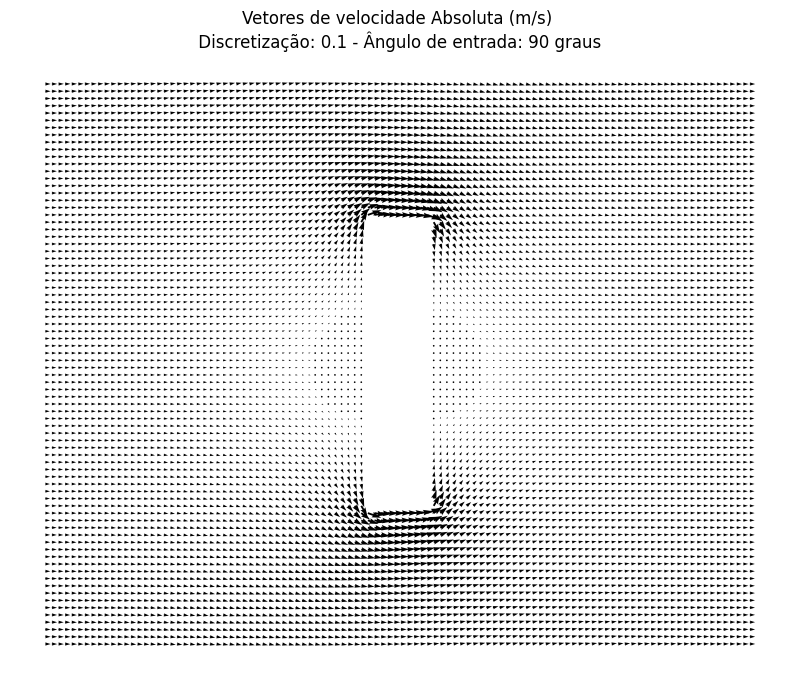

In [52]:
def plot_velocities_vectors(self):
    """
    Plot the velocities vectors in the flow field.
    
    """
    x_pos = []
    y_pos = []
    vel_in_x = []
    vel_in_y = []
    for row_id in range(self.num_of_rows):
        for col_id in range(self.num_of_cols):
            center_point = self.mesh[row_id][col_id]
            vx_value = center_point.get_del_streamline_del_y()
            vy_value = -center_point.get_del_streamline_del_x()
            if (vx_value != 0) and (vy_value != 0):
                x_pos.append(center_point.x_pos)
                y_pos.append(-center_point.y_pos)
                vel_in_x.append(vx_value)
                vel_in_y.append(vy_value)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.quiver(x_pos, y_pos, vel_in_x, vel_in_y)
    plt.title(f'Vetores de velocidade Absoluta (m/s)\n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
    plt.axis('off')
    plt.show()


plot_velocities_vectors(m)

In [ ]:
def plot_velocities(self, plot_contour: bool = False):
        # Dados de posição e velocidade
        x_pos = []
        y_pos = []
        vel_in_x = []
        vel_in_y = []

        for row_id in range(self.num_of_rows):
            for col_id in range(self.num_of_cols):
                center_point = self.mesh[row_id][col_id]
                vx = center_point.get_del_streamline_del_y()
                vy = -center_point.get_del_streamline_del_x()

                if vx != 0 or vy != 0:
                    x_pos.append(center_point.x_pos)
                    y_pos.append(center_point.y_pos)
                    vel_in_x.append(vx)
                    vel_in_y.append(vy)
                    
        # Obtendo valores do mesh para o heatmap
        mesh_values = self.get_parameter_value(velocity=True)
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True

        fig, ax = plt.subplots(figsize=(10, 8))

        # Plotando o heatmap
        sns.heatmap(mesh_values, annot=False, cmap='turbo', linewidths=0, mask=mask, cbar_kws={'extend': 'both'}, ax=ax)

        # Plotando os vetores de velocidade
        ax.quiver(x_pos, y_pos, vel_in_x, vel_in_y, angles='xy', scale_units='xy', scale=1, color='white')

        if plot_contour:
            nonzero_values = mesh_values[mesh_values != 0]
            levels = np.percentile(nonzero_values, np.linspace(0, 100, num=10))  
            ax.contour(mesh_values, levels=levels, colors='k', linestyles='solid', linewidths=2, alpha=0.7,
                        extent=(0, mesh_values.shape[1], 0, mesh_values.shape[0]))

        plt.title(f'Velocidade Absoluta (m/s)\n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.legend()
        plt.show()

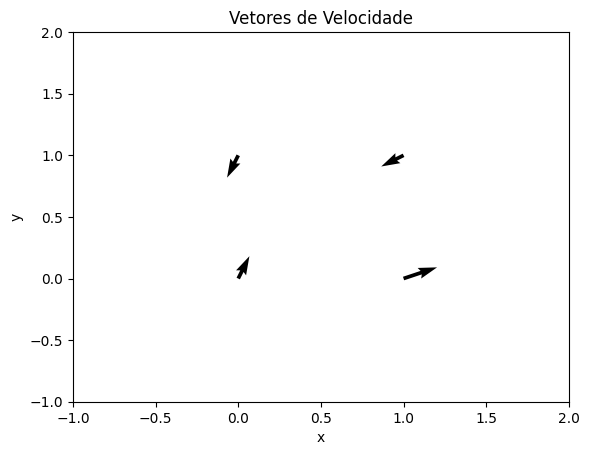

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class Ponto:
    def __init__(self, x, y, vx, vy):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy

# Criação da matriz de pontos
pontos = np.array([
    [Ponto(0, 0, 1, 2), Ponto(1, 0, 3, 1)],
    [Ponto(0, 1, -1, -2), Ponto(1, 1, -2, -1)]
])

# Inicializando os arrays para as posições e componentes de velocidade
x = []
y = []
u = []
v = []

# Populando os arrays com os dados dos pontos
for i in range(pontos.shape[0]):
    for j in range(pontos.shape[1]):
        ponto = pontos[i, j]
        x.append(ponto.x)
        y.append(ponto.y)
        u.append(ponto.vx)
        v.append(ponto.vy)

# Criando a figura e o eixo
fig, ax = plt.subplots()

# Plotando os vetores de velocidade
ax.quiver(x, y, u, v)

# Configurando os eixos
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Vetores de Velocidade')

# Exibindo o gráfico
plt.show()


In [6]:
#0.1 - 15 - drag: -18.49913298066041 lift: -357.43733428319894
#43874.60102998221 -2124751.2017328874

In [7]:
a = m.get_parameter_value(pressure=True)
np.sum(np.array(a)<0)

0

In [8]:
def plot_mesh(self): 
    
    mesh = [[None]*self.num_of_cols for _ in range(self.num_of_rows)]
    for c in range(self.num_of_cols):
        for r in range(self.num_of_rows):
            point = self.mesh[r][c]
            if point.is_in_airfoil:
                
            #elif point.is_surface_2:
            #    mesh[r][c] = 2
            #elif point.is_surface_3:
            #    mesh[r][c] = 3
            #elif point.is_surface_4:
            #    mesh[r][c] = 4
            else: 
                mesh[r][c] = 0
    plt.figure(figsize=(10, 8))
    plt.imshow(mesh)
    plt.title(f'Posição do Aerofólio \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
    plt.axis('off')
    plt.show()        
        
        
plot_mesh(m)

IndentationError: expected an indented block (1905347124.py, line 15)

In [ ]:
#36 min - 90 deg - 0.02 de disc - 4786 iterations

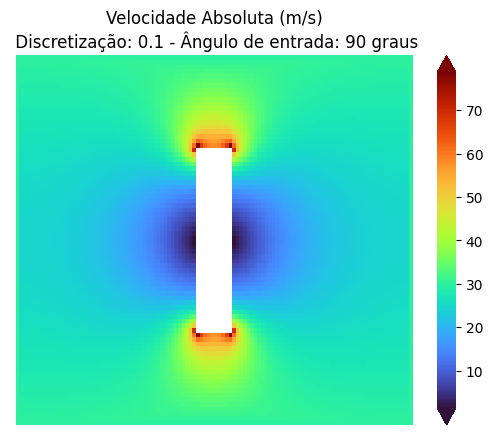

In [ ]:
m.plot_velocities()

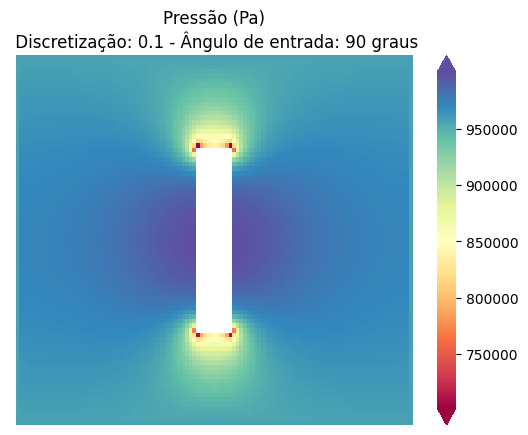

In [ ]:
m.plot_pressure()